In [5]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
import pandas as pd
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
from functools import partial

from plotly.subplots import make_subplots
import statsmodels.api as sm
import scipy.signal as signal

import numpy as np
from sklearn.decomposition import PCA


In [6]:
def distance_weighted(x,y,mu):
    return np.sum(np.array(mu)*(x-y)**2)

def generate_subsequences(data, window_size, step_size):
    num_points, num_variables = data.shape
    number_subs = int((num_points - window_size)/step_size) + 1  # Number of subsequences

    subsequences = np.zeros((number_subs, window_size, num_variables))

    for i in range(number_subs):
        subsequences[i, :, :] = data[i*step_size:i*step_size+window_size, :]
    return subsequences

def reconstructed_loss(reconstructed_points, initial_points):
    return np.linalg.norm(reconstructed_points - initial_points, ord=2, axis=1)


### Preprocessing

In [7]:
train_data = pd.read_csv('data/swat/SWaT_test.csv')

In [8]:
train_data["Normal/Attack"] = train_data["Normal/Attack"].replace({"Normal": 0, "Attack": 1})

In [9]:
train_data["Normal/Attack"].value_counts()
df_np_label = train_data.drop([" Timestamp", "Normal/Attack"], axis=1).values

In [10]:
#data_without_cte = train_data.drop(columns = constant_channel_names + ["Unnamed: 0","Normal/Attack"]).values
#df_np_label_reduced = data_without_cte[::, 1:]
data_np = train_data.drop(columns = ["Unnamed: 0","Normal/Attack", " Timestamp"]).values

In [11]:
# Create a PCA instance
n_components_analysis = 20
pca = PCA(n_components = n_components_analysis)

# Fit the data and transform it
data_pca = pca.fit_transform(data_np)

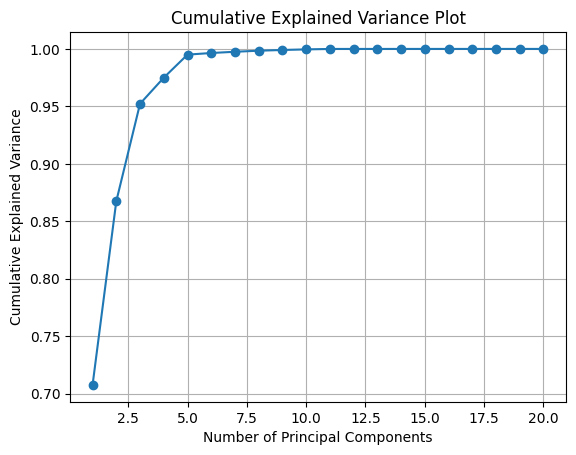

[0.70763667 0.86754367 0.9522937  0.97496631 0.99503435 0.99644622
 0.99752941 0.99844056 0.9990747  0.99960153 0.99996889 0.99998065
 0.99998801 0.99999348 0.9999954  0.99999636 0.99999719 0.99999796
 0.99999868 0.99999896]


In [12]:
# Check the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot')
plt.grid(True)
plt.show()
print(cumulative_explained_variance)

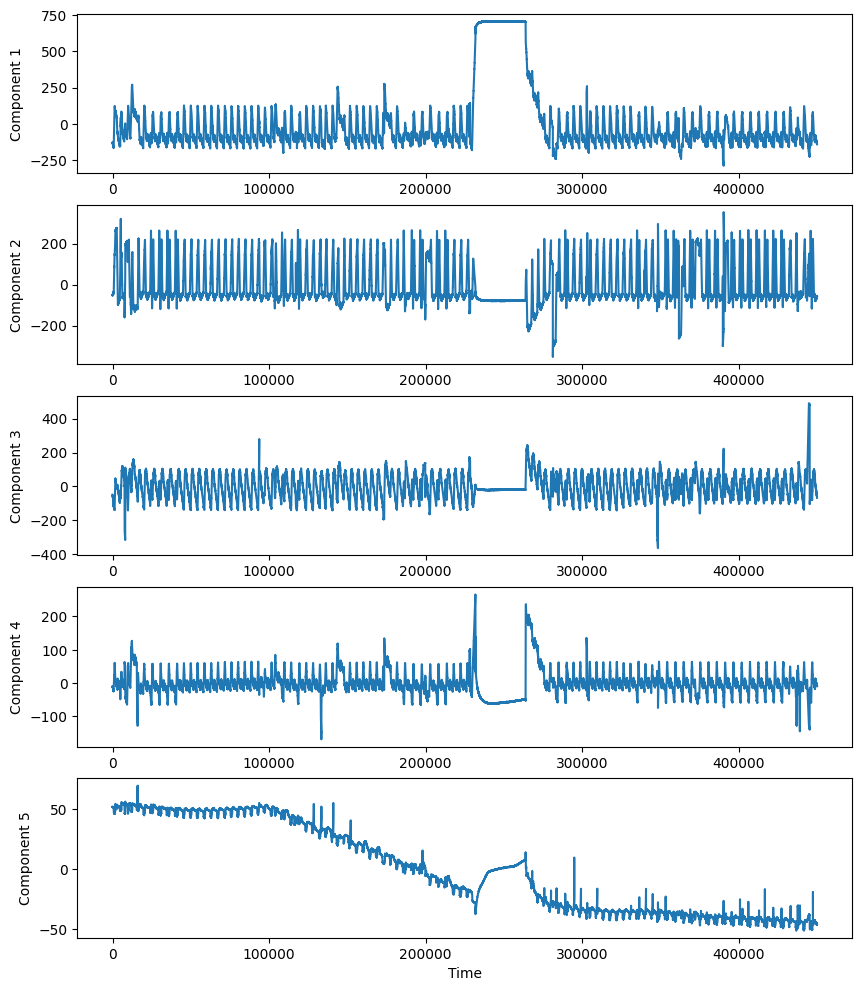

In [13]:

# Plot the first 5 components in 5 subplots
fig, axes = plt.subplots(5, 1, figsize=(10, 12))

for i in range(5):
    axes[i].plot(data_pca[:, i])
    axes[i].set_ylabel(f'Component {i+1}')

plt.xlabel('Time')
plt.show()

In [14]:
from scipy.signal import find_peaks
n_components = 5
periodicity = []
for i in range(n_components):
    signal_periodic = data_pca[45000:101000, i]
    fourier_transform = np.fft.fft(signal_periodic)
    frequencies = np.fft.fftfreq(len(signal_periodic), 1)

    peaks, _ = find_peaks(np.abs(fourier_transform), height=0.2e6)
    periodicity.append(1/frequencies[peaks[:3]])
    # plt.subplot(3, 1, 1)
    # plt.plot( data_pca[:, i])
    # plt.title('Original Signal')
    # plt.xlabel('Time')
    # plt.ylabel('Amplitude')

    # plt.subplot(3, 1, 2)
    # plt.plot( signal_periodic)
    # plt.title('zoom Signal')
    # plt.xlabel('Time')
    # plt.ylabel('Amplitude')

    # plt.subplot(3, 1, 3)
    # plt.plot(frequencies, np.abs(fourier_transform))
    # plt.scatter(frequencies[peaks], np.abs(fourier_transform)[peaks], color='red', marker='x', label='Local Maxima')

    # plt.title('Fourier Transform')
    # plt.xlabel('Frequency (Hz)')
    # plt.ylabel('Amplitude')
    # plt.xlim(0,0.002)
    # plt.tight_layout()
    # plt.show()


In [15]:
main_periodicity = periodicity[0][0]
print("Main periodicity in seconds", main_periodicity)
downsampling_rate = int(main_periodicity/40)

Main periodicity in seconds 4307.692307692308


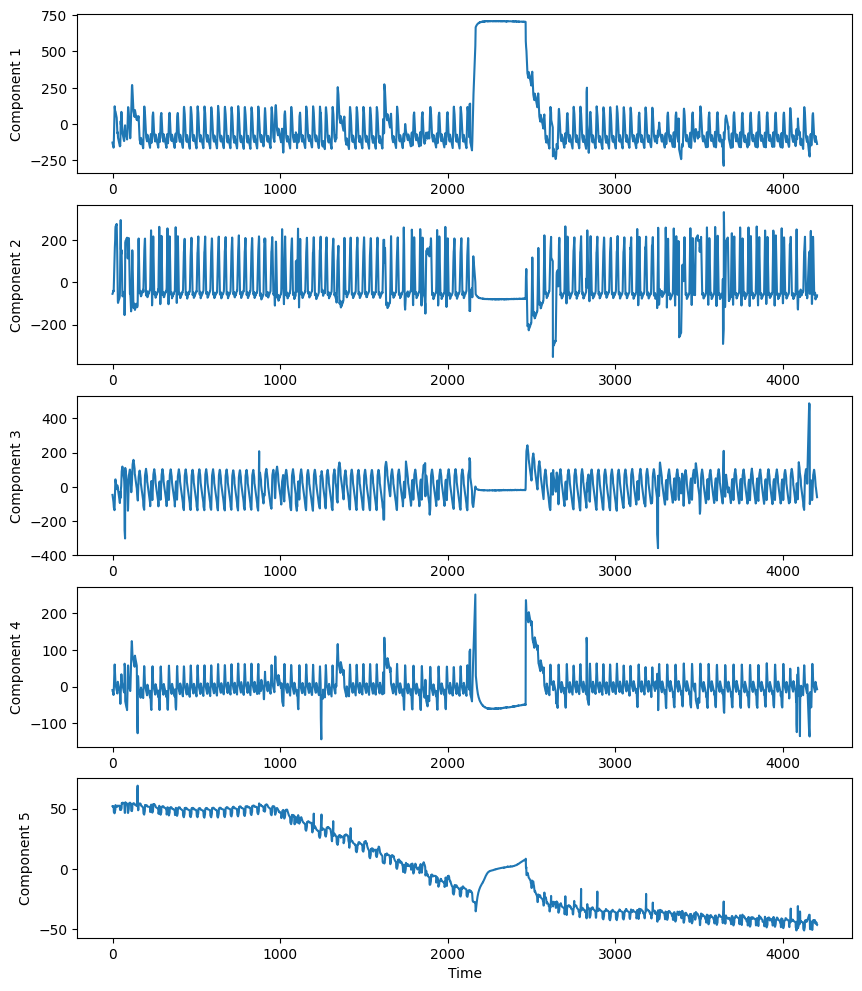

In [16]:
### Downsample the data 

# Plot the first 5 components in 5 subplots
fig, axes = plt.subplots(5, 1, figsize=(10, 12))

for i in range(5):
    axes[i].plot(data_pca[::downsampling_rate, i])
    axes[i].set_ylabel(f'Component {i+1}')

plt.xlabel('Time')
plt.show()

### Anomaly detection

#### Generate subsequences for shapes and amplitudes

In [17]:
data_pca_reduced = data_pca[:,:n_components]

window_size = int(main_periodicity/downsampling_rate)

stride =int(window_size/5)
sequences = generate_subsequences(data_pca_reduced[::downsampling_rate], window_size, stride)
label_sequences = generate_subsequences(train_data["Normal/Attack"].values.reshape(-1,1)[::downsampling_rate], window_size, stride)

print("window size = ", window_size)
print("stride = ", stride)

window size =  40
stride =  8


In [18]:
sequences_acf = np.zeros_like(sequences)

In [19]:
sequences_copy = sequences.copy()

for i in range(sequences_copy.shape[0]):
    for j in range(sequences_copy.shape[2]):

        # check if all values are the same
        if np.all(sequences_copy[i, :, j] == sequences_copy[i, 0, j]):
            sequences_copy[i, 0, j] += 0.0001
            # print("warning: constant timeseries")
            
        sequences_acf[i, :, j] = sm.tsa.acf(
            sequences_copy[i, :, j], nlags=len(sequences_copy[i, :, j]) - 1
        )

# sequences_acf[np.isnan(sequences_acf)] = sequences[np.isnan(sequences_acf)]

In [20]:
data_for_clustering = sequences.reshape(sequences.shape[0], -1)
data_for_clustering_shapes = sequences_acf.reshape(sequences_acf.shape[0], -1)

#### Fuzzy C-Means on amplitude using naive mu

In [21]:
mu = [1 / data_for_clustering.shape[1] for i in range(data_for_clustering.shape[1])]

cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    data_for_clustering.T,
    3, # N cluster
    2, # fuzzy coef
    metric=partial(distance_weighted, mu=mu),
    error=0.005,
    maxiter=1000,
    init=None,
)

# Reconstruction of initial points
reconstructed_points = np.dot(u.T, cntr) / np.sum(u, axis=0)[:, None]

In [22]:
loss = reconstructed_loss(reconstructed_points, data_for_clustering)


In [23]:
label_reshaped = np.max(label_sequences, axis=1)
# Select points with label 1
label_1_indices = np.where(label_reshaped == 1)[0]

In [24]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(len(loss)), y=loss, mode="lines", name="Loss"))
fig.add_trace(
    go.Scatter(
        x=label_1_indices, y=loss[label_1_indices], mode="markers", name="Attack"
    )
)

fig

#### Fuzzy C-means on shapes with ACF

In [25]:
mu = [
    1 / data_for_clustering_shapes.shape[1]
    for i in range(data_for_clustering_shapes.shape[1])
]

cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    data_for_clustering_shapes.T,
    3,  # N cluster
    2,  # jsp
    metric=partial(distance_weighted, mu=mu),
    error=0.005,
    maxiter=1000,
    init=None,
)

# Reconstruction of initial points
reconstructed_points = np.dot(u.T, cntr) / np.sum(u, axis=0)[:, None]

In [26]:
loss = reconstructed_loss(reconstructed_points, data_for_clustering_shapes)

In [27]:
label_reshaped = np.max(label_sequences, axis=1)
# Select points with label 1
label_1_indices = np.where(label_reshaped == 1)[0]

In [28]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(len(loss)), y=loss, mode="lines", name="Loss"))
fig.add_trace(
    go.Scatter(
        x=label_1_indices, y=loss[label_1_indices], mode="markers", name="Attack"
    )
)

fig

### Optimization

In [36]:
from utils import optimizer as opt

N_cluster = 2
model = "amplitude"

if model == "amplitude":
    data_for_clustering_opt = data_for_clustering

else:
    data_for_clustering_opt = data_for_clustering_shapes

algorithm_param = {
    "max_num_iteration": 20,
    "population_size": 20,
    "mutation_probability": 0.1,
    "elit_ratio": 0.05,
    "crossover_probability": 0.5,
    "parents_portion": 0.3,
    "crossover_type": "uniform",
    "max_iteration_without_improv": None,
}

In [37]:
optimizer = opt(
    N_cluster=N_cluster,
    data=data_for_clustering_opt,
    window_size=window_size,
    ga_opt_parameters=algorithm_param,
)

 The best solution found:                                                                           
 [0.43241759 0.49711708 0.00653132 0.25517654 0.49993477]

 Objective function:
 512150.57040038647


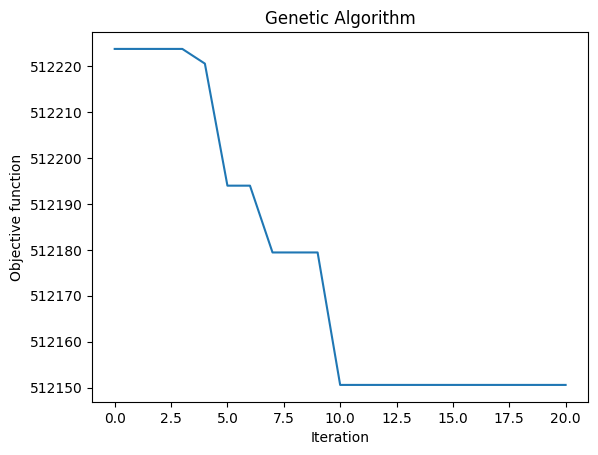

In [38]:
optimizer.run_ga()

In [39]:
optimizer.run_pso(max_iter=20)

  0%|          | 0/20 [00:00<?, ?it/s]

In [41]:
convergence_ga = optimizer.convergence_ga
solution_ga = optimizer.solution_ga
fitness_pso = optimizer.fitness_pso
solution_pso = optimizer.solution_pso

print(f"ga: {convergence_ga[-1]}, pso : {fitness_pso}")

ga: 512150.57040038647, pso : 512048.3539002576


In [46]:
print(f"ga: {solution_ga['variable']}, \n pso : {solution_pso}")

ga: [0.43241759 0.49711708 0.00653132 0.25517654 0.49993477], 
 pso : [ 46.56782264 153.04942333   0.           0.         127.4180994 ]


In [1]:
# optimizer.dict_opt_save
# optimizer.dict_opt_save_pso

In [47]:
solution = solution_ga

### Use the optimization result to run the reconstruction loss

In [53]:
opt_mu = solution["variable"]
win_len = data_for_clustering_opt.shape[1] // len(opt_mu)

opt_mu = opt_mu / opt_mu.sum()  # normalize the coefficients
opt_mu = np.repeat(opt_mu, win_len)

In [54]:
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data_for_clustering_opt.T,
    N_cluster, # N cluster
    2, #
    metric=partial(distance_weighted, mu=opt_mu),
    error=0.005,
    maxiter=1000,
    init=None,
)

# Reconstruction of initial points
opt_reconstructed_points = np.dot(u.T, cntr) / np.sum(u, axis=0)[:, None]

In [55]:
opt_loss = reconstructed_loss(opt_reconstructed_points, data_for_clustering_opt)

In [56]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(len(opt_loss)), y=opt_loss, mode="lines", name="Loss"))
fig.add_trace(
    go.Scatter(
        x=label_1_indices, y=opt_loss[label_1_indices], mode="markers", name="Attack"
    )
)

fig

### Metric : combining the subsequences to calculate a score on the og TS

In [57]:
def upscale_signal(subsequences, original_size, stride, window_length, operator=np.maximum):
    upscaled_signal = np.zeros(original_size)  # Initialize upscaled signal array

    for i, subsequence in enumerate(subsequences):
        start_index = i * stride
        end_index = start_index + window_length
        upscaled_signal[start_index:end_index] = operator(upscaled_signal[start_index:end_index], subsequence)

    return upscaled_signal[upscaled_signal > 0]

data_pca_reduced_downsampled = data_pca_reduced[::downsampling_rate].copy()
total_loss = upscale_signal(opt_loss, data_pca_reduced_downsampled.shape[0], stride, window_size, operator=np.maximum)

In [58]:
fig = go.Figure()

temp = np.where(train_data["Normal/Attack"][::downsampling_rate].values == 1)[0]

fig.add_trace(go.Scatter(x=np.arange(len(total_loss)), y=total_loss, mode="lines", name="opt Loss"))
fig.add_trace(
    go.Scatter(
        x=temp, y=total_loss[temp], mode="markers", name="Attack"
    )
)

fig